<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: West Nile Virus Prediction

--- 
# Notebook 1

This notebook consists of:
- Introduction and problem statement
- Data cleaning and exploratory data analysis
---

# 1. Introduction

West Nile virus is the single-stranded virus that causes West Nile fever. West Nile virus can be transmitted to humans by the bite of an infected mosquito. It first emerged in the United States in the New York metropolitan area in 1999, and has since spread across the country.<sup>1</sup>

In Illinois, West Nile virus was first identified in September 2001 in the Chicago area. The following year, the state's first human cases and deaths from West Nile disease were recorded. By the end of 2002, Illinois had counted more human cases (884) and deaths (64) than any other state in the United States.<sup>1</sup>

By 2004, the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today - a clear sign that the West Nile virus has become an endemic in Chicago.

# 2. Problem Statement

Due to the endemic of West Nile Virus in Chicago, the Department of Public Health has set up a surveillance and control system through which weather, location, testing, and spraying data was collected. CDPH has contacted our team to develop a model to predict the locations where there would be West Nile virus outbreaks.

Using these available datasets, the model will help the City of Chicago and CPHD more efficiently and effectively target spraying of specific neighbourhoods with higher risk of West Nile Virus. This can help the City of Chicago save costs while still keeping the virus at bay. Our model efficacy will be assessed by the Kaggle submission.

# 3. Loading the Datasets

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity

In [2]:
# load datasets
weather = pd.read_csv('../assets/weather.csv')
train = pd.read_csv('../assets/train.csv')
test = pd.read_csv('../assets/test.csv')
spray = pd.read_csv('../assets/spray.csv')
sampleSubmission = pd.read_csv('../assets/sampleSubmission.csv')

In [3]:
# load the map
mapdata = np.loadtxt('../assets/mapdata_copyright_openstreetmap_contributors.txt')
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

In [4]:
# look at the train dataset
print(train.shape)
train.info()

(10506, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


The **train** dataset appears to have no nulls present in the data.

In [5]:
# look at the test dataset
print(test.shape)
test.info()

(116293, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      116293 non-null  int64  
 1   Date                    116293 non-null  object 
 2   Address                 116293 non-null  object 
 3   Species                 116293 non-null  object 
 4   Block                   116293 non-null  int64  
 5   Street                  116293 non-null  object 
 6   Trap                    116293 non-null  object 
 7   AddressNumberAndStreet  116293 non-null  object 
 8   Latitude                116293 non-null  float64
 9   Longitude               116293 non-null  float64
 10  AddressAccuracy         116293 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


**test** also seems to have no nulls.<br>
When coparing to the columns in the **test** data, there is no `NumMosquitos` and `WnvPresent` columns.<br>
`WnvPresent` is what we are trying to predict.
There is one additional column called `ID` that is used for submission purposes.

In [6]:
# look at spray dataset
print(spray.shape)
spray.info()

(14835, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


**spray** appears to have some nulls in `Time` column.<br>
Another important observation is that the `Date` Dtype is 'object', and thus will need to be converted to the proper 'datetime' format.

In [7]:
# look at weather dataset
print(weather.shape)
weather.info()

(2944, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 


**weather** seems to have no nulls.<br>
However, `Date` appears to be in the wrong 'object' format. It should be 'datetime'.<br>
Some columns whose Dtype that should be 'int' of 'float' values also appear to be in 'object' format. These are: 
**['Tavg', ' WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'AvgSpeed']**

# Data Dictionary

|Feature|Dataset|Type|Description|
|---|---|---|---|
|id|test_final|int|ID number of the record|
|species|train_final/test_final|float|Mosquito species in trap|
|latitude|train_final/test_final|float|Latitude retrieved from GeoCoder|
|longtitude|train_final/test_final|float|Longitude retrieved from GeoCoder|
|month|train_final/test_final|int|month of the WNV test is performed|
|week|train_final/test_final|int|week of the WNV test is performed|
|day|train_final/test_final|int|day of the WNV test is performed|
|tmax|train_final/test_final|float|maximum daily temperature (F)|
|tmin|train_final/test_final|float|minimum daily temperature (F)|
|tavg|train_final/test_final|float|average daily temperature (F)|
|dewpoint|train_final/test_final|float|average dewpoint (F)|
|wetbulb|train_final/test_final|float|average wet bulb|
|heat|train_final/test_final|float|heating degree days|
|cool|train_final/test_final|float|cooling degree days|
|preciptotal|train_final/test_final|float|total daily rainfall (inch)|
|stnpressure|train_final/test_final|float|average atmospheric pressure (inch Hg)|
|sealevel|train_final/test_final|float|average sea level pressure (inch Hg)|
|resultspeed|train_final/test_final|float|resultant wind speed (mph)|
|resultdir|train_final/test_final|float|resultant wind direction (degrees)|
|avgspeed|train_final/test_final|float|average wind speed (mph)|
|cluster_0 to cluster_37|train_final/test_final|uint8|38 clusters base on trap location and numbers of mosquitos|

# 4. EDA on the `train` Dataset

## 4.1 Initial Analysis

In [8]:
# convert all the train column names to lowercase so it is easier to work with
train.columns= train.columns.str.lower()
train.columns

Index(['date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'nummosquitos', 'wnvpresent'],
      dtype='object')

In [9]:
# convert all the column names to lowercase so it is easier to work with
test.columns= test.columns.str.lower()
test.columns

Index(['id', 'date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy'],
      dtype='object')

In [10]:
train['date'] = pd.to_datetime(train.date)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    10506 non-null  datetime64[ns]
 1   address                 10506 non-null  object        
 2   species                 10506 non-null  object        
 3   block                   10506 non-null  int64         
 4   street                  10506 non-null  object        
 5   trap                    10506 non-null  object        
 6   addressnumberandstreet  10506 non-null  object        
 7   latitude                10506 non-null  float64       
 8   longitude               10506 non-null  float64       
 9   addressaccuracy         10506 non-null  int64         
 10  nummosquitos            10506 non-null  int64         
 11  wnvpresent              10506 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), ob

In [11]:
train.head(2)

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


In [12]:
# look at the latest and earliest dates
print(f'The most recent date is {train.date.sort_values(ascending=False).iloc[0]}.')
print(f'The oldest date is {train.date.sort_values(ascending=False).iloc[-1]}.')

The most recent date is 2013-09-26 00:00:00.
The oldest date is 2007-05-29 00:00:00.


the **train** dataset spans over 6 years.

## 4.2 West Nile Virus (WNV) Analysis

In [13]:
train['wnvpresent'].value_counts()

0    9955
1     551
Name: wnvpresent, dtype: int64

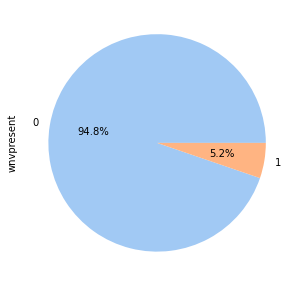

In [14]:
# what is the proportion of classes in wnvpresent?
colors = sns.color_palette('pastel')
train['wnvpresent'].value_counts().plot.pie(figsize=(5,5), colors=colors, autopct="%.1f%%");

The train datasets are **imbalanced** with about **5.2%** of WNV Present cases

In [15]:
# replace space with _ under species type
train['species'] = [train['species'].apply(lambda x: x.replace(' ','_').lower()).values][0]
test['species'] = [test['species'].apply(lambda x: x.replace(' ','_').lower()).values][0]

In [16]:
train['species'].value_counts().sort_index()

culex_erraticus              1
culex_pipiens             2699
culex_pipiens/restuans    4752
culex_restuans            2740
culex_salinarius            86
culex_tarsalis               6
culex_territans            222
Name: species, dtype: int64

In [17]:
test['species'].value_counts().sort_index()

culex_erraticus           14345
culex_pipiens             14521
culex_pipiens/restuans    15359
culex_restuans            14670
culex_salinarius          14355
culex_tarsalis            14347
culex_territans           14351
unspecified_culex         14345
Name: species, dtype: int64

test datasets have one more species __unspecified_culex__ which is not available in train datasets

In [18]:
# number of mosquitos of each sub-species
train.groupby(by='species')['nummosquitos'].sum()

species
culex_erraticus               7
culex_pipiens             44671
culex_pipiens/restuans    66268
culex_restuans            23431
culex_salinarius            145
culex_tarsalis                7
culex_territans             510
Name: nummosquitos, dtype: int64

In [19]:
# percentage of majority CULEX PIPIENS, CULEX RESTUANS and CULEX PIPIENS/RESTUANS species
train.groupby(by='species')['nummosquitos'].sum()[1:4]/train.groupby(by='species')['nummosquitos'].sum()[:].sum()

species
culex_pipiens             0.330801
culex_pipiens/restuans    0.490732
culex_restuans            0.173513
Name: nummosquitos, dtype: float64

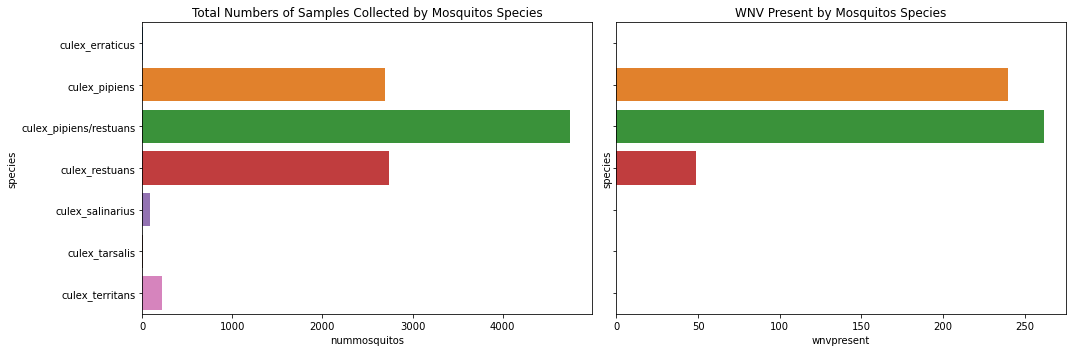

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5), sharey=True)
sns.barplot(data= train.groupby(['species']).agg({'nummosquitos':'count','wnvpresent':'sum'}).reset_index(),
            x='nummosquitos', y='species', ax=ax[0])
ax[0].set_title('Total Numbers of Samples Collected by Mosquitos Species')

sns.barplot(data= train.groupby(['species']).agg({'nummosquitos':'sum','wnvpresent':'sum'}).reset_index(),
            x='wnvpresent', y='species', ax=ax[1])
ax[1].set_title('WNV Present by Mosquitos Species')

plt.tight_layout();

CULEX PIPIENS, CULEX RESTUANS and CULEX PIPIENS/RESTUANS make up about **99%** of the species trapped.

Compare the number of WNV cases by month.

In [21]:
train.groupby(['wnvpresent','species']).sum()['nummosquitos'].to_frame().unstack().T

wnvpresent                                 0       1
             species                                
nummosquitos culex_erraticus             7.0     NaN
             culex_pipiens           37942.0  6729.0
             culex_pipiens/restuans  59145.0  7123.0
             culex_restuans          22764.0   667.0
             culex_salinarius          145.0     NaN
             culex_tarsalis              7.0     NaN
             culex_territans           510.0     NaN

In [22]:
# get year, month, week and day
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['week'] = train['date'].dt.isocalendar().week.astype('int') 
train['day'] = train['date'].dt.day

print(train.shape)
train.head(2)

(10506, 16)


,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,year,month,week,day
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",culex_pipiens/restuans,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,2007,5,22,29
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",culex_restuans,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,2007,5,22,29


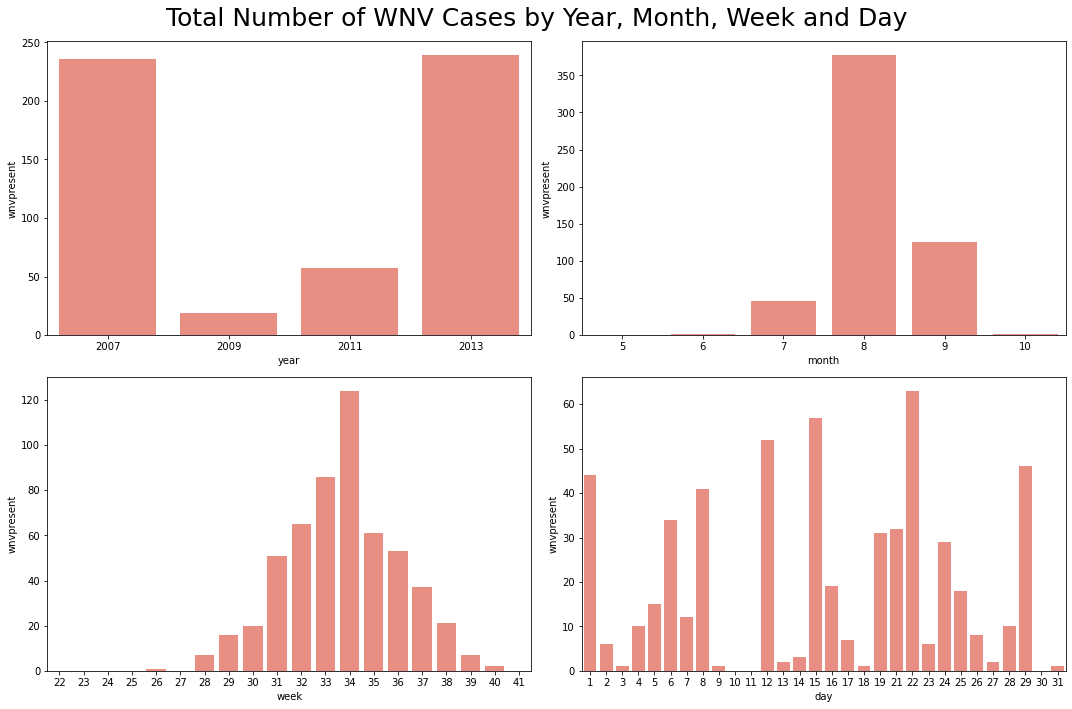

In [23]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
sns.barplot(data= train.groupby('year')['wnvpresent'].sum().reset_index(), 
            x='year', y='wnvpresent',ax=ax[0,0], color='salmon')

sns.barplot(data= train.groupby('month')['wnvpresent'].sum().reset_index(), 
            x='month', y='wnvpresent',ax=ax[0,1], color='salmon')

sns.barplot(data= train.groupby('week')['wnvpresent'].sum().reset_index(), 
            x='week', y='wnvpresent',ax=ax[1,0], color='salmon')

sns.barplot(data= train.groupby('day')['wnvpresent'].sum().reset_index(), 
            x='day', y='wnvpresent',ax=ax[1,1], color='salmon')

plt.suptitle('Total Number of WNV Cases by Year, Month, Week and Day', y=0.98, fontsize=25)
plt.tight_layout();

- From the barplots above, both year **2007** and **2013** have the highest numbers of WNV present cases and majority of it distributed in July August and September. This could be due to July ~ September being the summer period, where there is higher mosquitos activity.
- In term of weeks, the WNV spreading between week 28 to week 39 and the cases were quite normaly distributed. This could be due to these months being the summer period, where there is higher mosquitos activity.
- there was no common pattern of the WNV present cases distributing by days

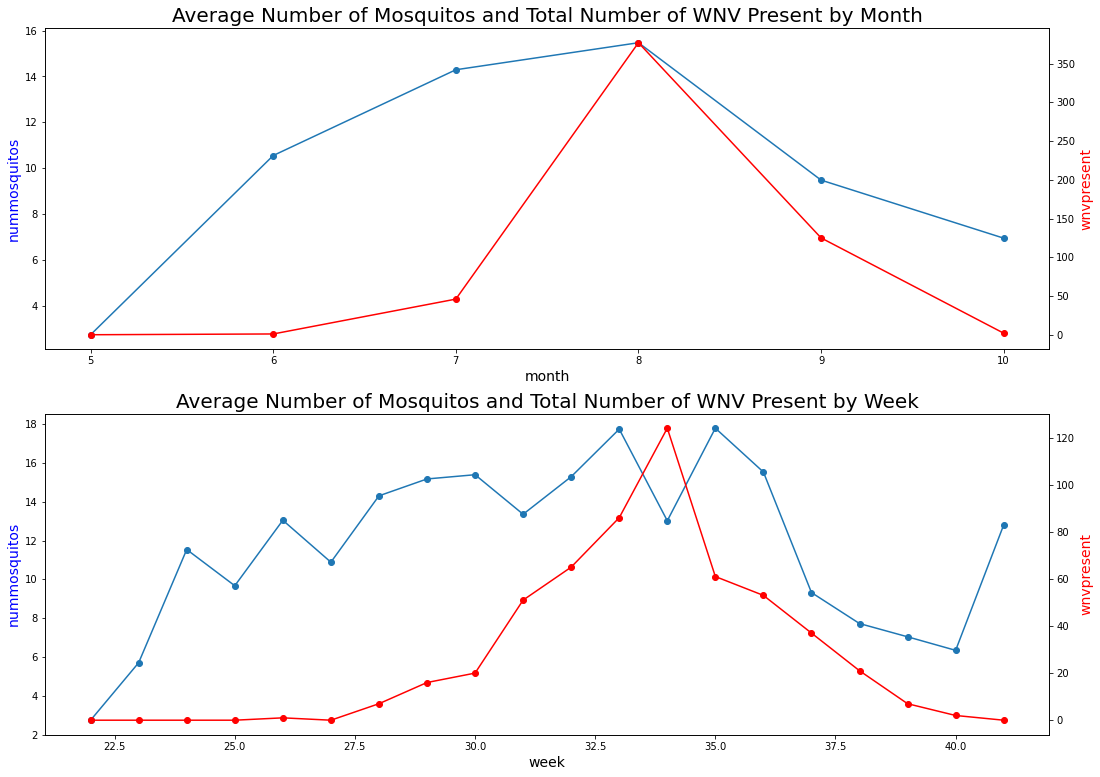

In [24]:
fig, ax = plt.subplots(nrows=2, figsize=(18,13))
ax[0].plot(train.groupby('month')['nummosquitos'].mean(), marker='o',label='nummosquitos')
ax[0].set_ylabel("nummosquitos",color="blue",fontsize=14)
ax[0].set_xlabel("month",fontsize=14)
ax2=ax[0].twinx()
ax2.plot(train.groupby('month')['wnvpresent'].sum(), marker='o', color='r')
ax2.set_ylabel("wnvpresent",color="red",fontsize=14)
ax[0].set_title('Average Number of Mosquitos and Total Number of WNV Present by Month', fontsize=20)

ax[1].plot(train.groupby('week')['nummosquitos'].mean(), marker='o',label='nummosquitos')
ax[1].set_ylabel("nummosquitos",color="blue",fontsize=14)
ax2=ax[1].twinx()
ax2.plot(train.groupby('week')['wnvpresent'].sum(), marker='o', color='r')
ax2.set_ylabel("wnvpresent",color="red",fontsize=14)
ax[1].set_xlabel("week",fontsize=14)
ax[1].set_title('Average Number of Mosquitos and Total Number of WNV Present by Week', fontsize=20);

- We drill further into month and week and we found out that average numbers of mosquitos increased from May and peak at August while the number of WNV present cases peak in August as well.
- As it is summer period for Chicago during June to August, hence the weather and temperature may be the factors that bringing up the number of mosquitos and resulting in higher number of WNV present.

## 4.3 Locations with high mosquito count and WNV clusters

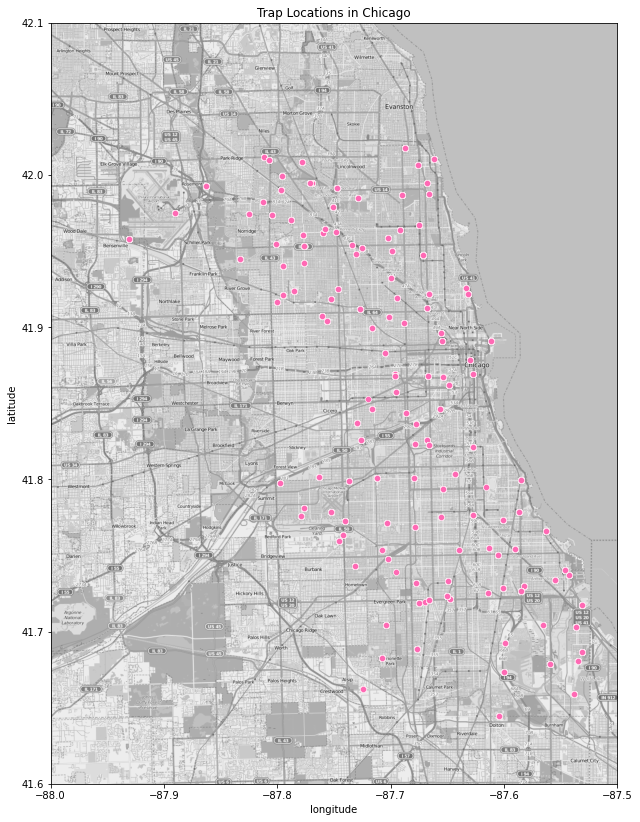

In [25]:
# trap locations by latitude and longitude

fig, ax = plt.subplots(figsize=(15,14))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
sns.scatterplot(data=train, y='latitude', x='longitude', color='hotpink')
plt.title('Trap Locations in Chicago');

In [26]:
# look at mosquitos trapped and wnv presence by address
total_mosquito = train.groupby(by='address')[['nummosquitos', 'wnvpresent']].sum()
print(total_mosquito.shape)
total_mosquito.head()

(138, 2)


,nummosquitos,wnvpresent
address,,
"1000 East 67th Street, Chicago, IL 60637, USA",852,4
"1000 North Central Park Avenue, Chicago, IL 60651, USA",1802,8
"1000 South California Avenue, Chicago, IL 60612, USA",125,0
"1000 West 95th Street, Chicago, IL 60643, USA",185,1
"1100 North Artesian Avenue, Chicago, IL 60622, USA",666,4


In [27]:
# get the corresponding latitudes and longitudes
area = train.groupby(by='address')[['latitude', 'longitude']].mean()
print(area.shape)
area.head()

(138, 2)


,latitude,longitude
address,,
"1000 East 67th Street, Chicago, IL 60637, USA",41.773215,-87.600880
"1000 North Central Park Avenue, Chicago, IL 60651, USA",41.899230,-87.716788
"1000 South California Avenue, Chicago, IL 60612, USA",41.869107,-87.696293
"1000 West 95th Street, Chicago, IL 60643, USA",41.721474,-87.648064
"1100 North Artesian Avenue, Chicago, IL 60622, USA",41.903002,-87.688267


In [28]:
hot_spots = pd.concat([total_mosquito, area], axis=1)
print(hot_spots.shape)
hot_spots.head()

(138, 4)


,nummosquitos,wnvpresent,latitude,longitude
address,,,,
"1000 East 67th Street, Chicago, IL 60637, USA",852,4,41.773215,-87.600880
"1000 North Central Park Avenue, Chicago, IL 60651, USA",1802,8,41.899230,-87.716788
"1000 South California Avenue, Chicago, IL 60612, USA",125,0,41.869107,-87.696293
"1000 West 95th Street, Chicago, IL 60643, USA",185,1,41.721474,-87.648064
"1100 North Artesian Avenue, Chicago, IL 60622, USA",666,4,41.903002,-87.688267


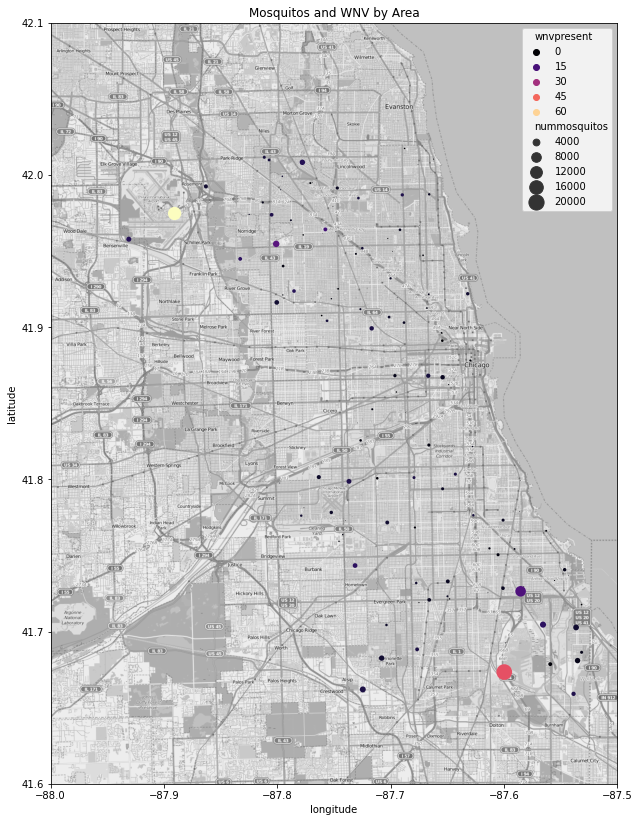

In [29]:
# look at the scale of outbreak and mosquito number

fig, ax = plt.subplots(figsize=(15,14))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
sns.scatterplot(data=hot_spots, y='latitude', x='longitude',
                size='nummosquitos', sizes=(0,250), hue='wnvpresent',
                palette='magma' )
plt.title('Mosquitos and WNV by Area');

As can be seen from the plot above, there are 2 areas with high mosquito count and high number of wnv cases.

In [30]:
# where are these 2 areas?
hot_spots.sort_values(by='wnvpresent', ascending=False).head(2)

,nummosquitos,wnvpresent,latitude,longitude
address,,,,
"ORD Terminal 5, O'Hare International Airport, Chicago, IL 60666, USA",15386,66,41.974689,-87.890615
"South Doty Avenue, Chicago, IL, USA",21668,41,41.673408,-87.599862


The 2 areas are **ORD Terminal 5, O'Hare International Airport, Chicago, IL 60666, USA** and **South Doty Avenue, Chicago, IL, USA**.

# 5. EDA on `weather` dataset

## 5.1 Initial Analysis

In [31]:
# convert all the weather column names to lowercase so it is easier to work with
weather.columns= weather.columns.str.lower()
weather.columns

Index(['station', 'date', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint',
       'wetbulb', 'heat', 'cool', 'sunrise', 'sunset', 'codesum', 'depth',
       'water1', 'snowfall', 'preciptotal', 'stnpressure', 'sealevel',
       'resultspeed', 'resultdir', 'avgspeed'],
      dtype='object')

In [32]:
# change date to datetime format
weather['date'] = pd.to_datetime(weather['date'])

print(weather.info())
weather.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station      2944 non-null   int64         
 1   date         2944 non-null   datetime64[ns]
 2   tmax         2944 non-null   int64         
 3   tmin         2944 non-null   int64         
 4   tavg         2944 non-null   object        
 5   depart       2944 non-null   object        
 6   dewpoint     2944 non-null   int64         
 7   wetbulb      2944 non-null   object        
 8   heat         2944 non-null   object        
 9   cool         2944 non-null   object        
 10  sunrise      2944 non-null   object        
 11  sunset       2944 non-null   object        
 12  codesum      2944 non-null   object        
 13  depth        2944 non-null   object        
 14  water1       2944 non-null   object        
 15  snowfall     2944 non-null   object        
 16  precip

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,codesum,depth,water1,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


Can see that there are quite a number of instances of 'M' (Missing Data) in the weather dataset. We need to see how many 'M's there are for each column.

In [33]:
weather.isin(['M']).sum()

station           0
date              0
tmax              0
tmin              0
tavg             11
depart         1472
dewpoint          0
wetbulb           4
heat             11
cool             11
sunrise           0
sunset            0
codesum           0
depth          1472
water1         2944
snowfall       1472
preciptotal       2
stnpressure       4
sealevel          9
resultspeed       0
resultdir         0
avgspeed          3
dtype: int64

There are 'M's present for `tavg`, `depart`, `wetbulb`, `heat`, `cool`, `depth`, `water1`, `snowfall`, `preciptotal` `stnpressure`, `sealevel` and `avgspeed`.<br>
Of these columns, `depart`, `depth`, `water1` and `snowfall` have a large number of 'M's. We shall investigate these first.

Another value to note is '  T' which stands for Trace.

In [34]:
weather.isin(['  T']).sum()

station          0
date             0
tmax             0
tmin             0
tavg             0
depart           0
dewpoint         0
wetbulb          0
heat             0
cool             0
sunrise          0
sunset           0
codesum          0
depth            0
water1           0
snowfall        12
preciptotal    318
stnpressure      0
sealevel         0
resultspeed      0
resultdir        0
avgspeed         0
dtype: int64

`snowfall` and `preciptotal` have '  T' in them - we will investigate further. 

In [35]:
weather['tavg'].unique()

array(['67', '68', '51', '52', '56', '58', 'M', '60', '59', '65', '70',
       '69', '71', '61', '55', '57', '73', '72', '53', '62', '63', '74',
       '75', '78', '76', '77', '66', '80', '64', '81', '82', '79', '85',
       '84', '83', '50', '49', '46', '48', '45', '54', '47', '44', '40',
       '41', '38', '39', '42', '37', '43', '86', '87', '89', '92', '88',
       '91', '93', '94', '90', '36'], dtype=object)

In [36]:
# depart - The Departure from Normal Temperature
weather[['depart']]

,depart
0,14
1,M
2,-3
3,M
4,2
...,...
2939,M
2940,-4
2941,M
2942,-6


Since there are a large number of 'M's, and we also have the `tmax`, `tmin` and `tavg`, we can drop this column.

In [37]:
# depth - The Depth of the snow
print(weather.depth.unique())
weather[['depth']]

['0' 'M']


,depth
0,0
1,M
2,0
3,M
4,0
...,...
2939,M
2940,0
2941,M
2942,0


For `depth`, the values are either '0' or 'M' - we may drop this column as well.

In [38]:
# water1 - Water from rainfall or melting snow
print(weather.water1.unique())
weather[['water1']]

['M']


,water1
0,M
1,M
2,M
3,M
4,M
...,...
2939,M
2940,M
2941,M
2942,M


For `water1`, all values are missing - it is therefore useless for our model and will be dropped.

In [39]:
# snowfall - amount of snowfall
print(weather.snowfall.unique())
weather[['snowfall']]

['0.0' 'M' '  T' '0.1']


,snowfall
0,0.0
1,M
2,0.0
3,M
4,0.0
...,...
2939,M
2940,0.0
2941,M
2942,0.1


With half the values in `snowfall` being 'M', we can drop this column as well.

The rest of the 'M's are very few. We can drop those rows in the dataset.

In [40]:
weather['preciptotal'].value_counts().sort_index()

  T      318
0.00    1577
0.01     127
0.02      63
0.03      46
        ... 
3.97       1
4.73       1
6.64       1
6.86       1
M          2
Name: preciptotal, Length: 168, dtype: int64

In [41]:
# preciptotal - amount of precipitation
print(weather.preciptotal.unique())
weather[['preciptotal']]

['0.00' '  T' '0.13' '0.02' '0.38' '0.60' '0.14' '0.07' '0.11' '0.09'
 '1.01' '0.28' '0.04' '0.08' '0.01' '0.53' '0.19' '0.21' '0.32' '0.39'
 '0.31' '0.42' '0.27' '0.16' '0.58' '0.93' '0.05' '0.34' '0.15' '0.35' 'M'
 '0.40' '0.66' '0.30' '0.24' '0.43' '1.55' '0.92' '0.89' '0.17' '0.03'
 '1.43' '0.97' '0.26' '1.31' '0.06' '0.46' '0.29' '0.23' '0.41' '0.45'
 '0.83' '1.33' '0.91' '0.48' '0.37' '0.88' '2.35' '1.96' '0.20' '0.25'
 '0.18' '0.67' '0.36' '0.33' '1.28' '0.74' '0.76' '0.71' '0.95' '1.46'
 '0.12' '0.52' '0.64' '0.22' '1.24' '0.72' '0.73' '0.65' '1.61' '1.22'
 '0.50' '1.05' '2.43' '0.59' '2.90' '2.68' '1.23' '0.62' '6.64' '3.07'
 '1.44' '1.75' '0.82' '0.80' '0.86' '0.63' '0.55' '1.03' '0.70' '1.73'
 '1.38' '0.44' '1.14' '1.07' '3.97' '0.87' '0.78' '1.12' '0.68' '0.10'
 '0.61' '0.54' '1.19' '0.75' '0.84' '1.29' '0.81' '1.15' '1.49' '1.57'
 '1.02' '1.30' '0.51' '0.85' '0.79' '0.77' '2.79' '3.15' '3.64' '4.73'
 '1.60' '0.57' '2.24' '1.90' '1.06' '1.88' '0.69' '2.17' '6.86' '0.49'
 '1

,preciptotal
0,0.00
1,0.00
2,0.00
3,0.00
4,0.00
...,...
2939,0.00
2940,0.00
2941,T
2942,0.03


We can drop the `preciptotal` column as well, since there already is a `dewpoint` column that is closely related to precipitation

## 5.2 Data cleaning of `weather` dataset

In [42]:
# drop due to high missing values
weather = weather.drop(columns=['water1', 'depth', 'snowfall','depart','codesum'])

In [43]:
# handling missing value for `preciptotal`
weather['preciptotal'].replace(['M', '  T'], 0, inplace=True)
weather['preciptotal'] = weather['preciptotal'].astype('float')

In [44]:
# impute the `tavg` using average of tmax and tmin
weather['tavg'] = (weather['tmax'] + weather['tmin'])/2

In [45]:
weather['cool'].unique()

array([' 2', ' 3', ' 0', 'M', ' 5', ' 4', ' 6', ' 8', ' 7', ' 9', '10',
       '13', '11', '12', ' 1', '15', '16', '17', '14', '20', '19', '18',
       '21', '22', '24', '27', '23', '26', '28', '29', '25'], dtype=object)

In [46]:
# impute the heating and cooling degree days
def impute_heat_cool(row):
    if row['cool'] == 'M' or row['heat'] == 'M':
        
        if row['tavg'] > 65:
            hcd = row['tavg'] - 65
            row['cool'] = hcd
            row['heat'] = 0
        
        elif row['tavg'] < 65:
            hcd = 65 - row['tavg']
            row['cool'] = 0
            row['heat'] = hcd

        else:
            row['cool'] = row['heat'] = 0
    return row

In [47]:
weather = weather.apply(impute_heat_cool, axis=1)

In [48]:
weather.isin(['M']).sum()[weather.isin(['M']).sum() > 0]

wetbulb        4
stnpressure    4
sealevel       9
avgspeed       3
dtype: int64

In [49]:
# not using sunrise and sunset
weather.drop(['sunrise','sunset'], axis=1, inplace=True)

In [50]:
weather.columns

Index(['station', 'date', 'tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb',
       'heat', 'cool', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed',
       'resultdir', 'avgspeed'],
      dtype='object')

In [51]:
weather[weather['avgspeed'] == "M"]

,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
87,2,2007-06-13,86,68,77.0,53,62,0,12,0.0,M,M,7.0,5,M
1745,2,2011-09-14,60,48,54.0,45,51,11,0,0.0,29.47,M,6.0,32,M
2067,2,2012-08-22,84,72,78.0,51,61,0,13.0,0.0,29.39,M,4.7,19,M


In [52]:
weather.sort_values('avgspeed').tail()

,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
2148,1,2012-10-02,69,53,61.0,50,55,4,0,0.0,29.15,29.86,9.6,3,9.9
1647,2,2011-07-27,92,72,82.0,66,71,0,17,0.0,29.21,29.84,6.0,16,9.9
87,2,2007-06-13,86,68,77.0,53,62,0,12,0.0,M,M,7.0,5,M
1745,2,2011-09-14,60,48,54.0,45,51,11,0,0.0,29.47,M,6.0,32,M
2067,2,2012-08-22,84,72,78.0,51,61,0,13.0,0.0,29.39,M,4.7,19,M


In [53]:
weather[weather['date'] == '2007-06-13']

,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
86,1,2007-06-13,87,60,73.5,53,62,0,9,0.0,29.36,30.09,7.2,5,8.6
87,2,2007-06-13,86,68,77.0,53,62,0,12,0.0,M,M,7.0,5,M


In [54]:
weather[weather['date'] == '2011-09-14']

,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
1744,1,2011-09-14,58,47,52.5,43,49,12,0,0.08,29.39,30.09,6.3,34,7.3
1745,2,2011-09-14,60,48,54.0,45,51,11,0,0.00,29.47,M,6.0,32,M


In [55]:
weather[weather['date'] == '2012-08-22']

,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
2066,1,2012-08-22,85,54,69.5,52,60,0,5,0.0,29.35,30.07,5.5,19,5.8
2067,2,2012-08-22,84,72,78.0,51,61,0,13.0,0.0,29.39,M,4.7,19,M


In [56]:
# impute the missing avgspeed with the avgspeed of station 1
for index in weather[weather['avgspeed'] == "M"].index:
    imputed_value = weather.loc[index-1]['avgspeed']
    weather.loc[index] = weather.loc[index].replace('M', imputed_value)
    
for index in weather[weather['wetbulb'] == "M"].index:
    imputed_value = weather.loc[index-1]['wetbulb']
    weather.loc[index] = weather.loc[index].replace('M', imputed_value)
    
for index in weather[weather['stnpressure'] == "M"].index:
    imputed_value = weather.loc[index-1]['stnpressure']
    weather.loc[index] = weather.loc[index].replace('M', imputed_value)
    
for index in weather[weather['sealevel'] == "M"].index:
    imputed_value = weather.loc[index-1]['sealevel']
    weather.loc[index] = weather.loc[index].replace('M', imputed_value)

In [57]:
weather.head(10)

,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2007-05-01,83,50,66.5,51,56,0,2,0.0,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68.0,51,57,0,3,0.0,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,50.5,42,47,14,0,0.0,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,51.5,42,47,13,0,0.0,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56.0,40,48,9,0,0.0,29.39,30.12,11.7,7,11.9
5,2,2007-05-03,67,48,57.5,40,50,7,0,0.0,29.46,30.12,12.9,6,13.2
6,1,2007-05-04,66,49,57.5,41,50,7,0,0.0,29.31,30.05,10.4,8,10.8
7,2,2007-05-04,78,51,64.5,42,50,0.5,0,0.0,29.36,30.04,10.1,7,10.4
8,1,2007-05-05,66,53,59.5,38,49,5,0,0.0,29.40,30.10,11.7,7,12.0
9,2,2007-05-05,66,54,60.0,39,50,5,0,0.0,29.46,30.09,11.2,7,11.5


In [58]:
weather.isin(['M']).sum()

station        0
date           0
tmax           0
tmin           0
tavg           0
dewpoint       0
wetbulb        0
heat           0
cool           0
preciptotal    0
stnpressure    0
sealevel       0
resultspeed    0
resultdir      0
avgspeed       0
dtype: int64

In [59]:
weather.isin(['  T']).sum()

station        0
date           0
tmax           0
tmin           0
tavg           0
dewpoint       0
wetbulb        0
heat           0
cool           0
preciptotal    0
stnpressure    0
sealevel       0
resultspeed    0
resultdir      0
avgspeed       0
dtype: int64

In [60]:
# check weather type
# there are multiple features which needed to be convereted into float type
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station      2944 non-null   int64         
 1   date         2944 non-null   datetime64[ns]
 2   tmax         2944 non-null   int64         
 3   tmin         2944 non-null   int64         
 4   tavg         2944 non-null   float64       
 5   dewpoint     2944 non-null   int64         
 6   wetbulb      2944 non-null   object        
 7   heat         2944 non-null   object        
 8   cool         2944 non-null   object        
 9   preciptotal  2944 non-null   float64       
 10  stnpressure  2944 non-null   object        
 11  sealevel     2944 non-null   object        
 12  resultspeed  2944 non-null   float64       
 13  resultdir    2944 non-null   int64         
 14  avgspeed     2944 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(5), object(6)
m

In [61]:
# columns whose values need to be converted
to_float = ['tavg', 'wetbulb', 'heat', 'cool', 'stnpressure', 'sealevel', 'avgspeed']

for col in to_float:
    weather[col] = weather[col].astype(float)

weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station      2944 non-null   int64         
 1   date         2944 non-null   datetime64[ns]
 2   tmax         2944 non-null   int64         
 3   tmin         2944 non-null   int64         
 4   tavg         2944 non-null   float64       
 5   dewpoint     2944 non-null   int64         
 6   wetbulb      2944 non-null   float64       
 7   heat         2944 non-null   float64       
 8   cool         2944 non-null   float64       
 9   preciptotal  2944 non-null   float64       
 10  stnpressure  2944 non-null   float64       
 11  sealevel     2944 non-null   float64       
 12  resultspeed  2944 non-null   float64       
 13  resultdir    2944 non-null   int64         
 14  avgspeed     2944 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int64(5)
memory usage

We can now proceed to select the relevant columns in the **weather** dateset. We will groupby based on date, and see how it affects the number of mosquitos and presence of the West Nile Virus.

## 5.3 Weather vs Number of Mosquitos and WNV

In [62]:
weather_exploratory = weather.groupby(by='date')[['tavg', 'dewpoint', 'wetbulb', 'heat', 'cool', 'stnpressure', 'avgspeed']].mean()
weather_exploratory

,tavg,dewpoint,wetbulb,heat,cool,stnpressure,avgspeed
date,,,,,,,
2007-05-01,67.25,51.0,56.5,0.00,2.5,29.140,9.40
2007-05-02,51.00,42.0,47.0,13.50,0.0,29.410,13.40
2007-05-03,56.75,40.0,49.0,8.00,0.0,29.425,12.55
2007-05-04,61.00,41.5,50.0,3.75,0.0,29.335,10.60
2007-05-05,59.75,38.5,49.5,5.00,0.0,29.430,11.75
...,...,...,...,...,...,...,...
2014-10-27,65.25,51.5,58.5,0.50,1.0,28.960,13.25
2014-10-28,56.75,39.0,47.5,8.00,0.0,29.190,15.10
2014-10-29,43.50,33.0,41.0,21.00,0.0,29.390,9.45


In [63]:
# group the nummosquitos and wnvpresent in train set by date
mos_virus = train.groupby(by='date')[['nummosquitos', 'wnvpresent']].sum()
mos_virus

,nummosquitos,wnvpresent
date,,
2007-05-29,40,0
2007-06-05,127,0
2007-06-26,216,0
2007-06-29,85,0
2007-07-02,240,0
...,...,...
2013-08-29,2645,38
2013-09-06,2510,32
2013-09-12,2210,23


In [64]:
# combine the mos_virus with weather_exploratory so we can do analysis
mos_vs_weather = pd.concat([mos_virus, weather_exploratory], axis=1).dropna().reset_index()
mos_vs_weather

,date,nummosquitos,wnvpresent,tavg,dewpoint,wetbulb,heat,cool,stnpressure,avgspeed
0,2007-05-29,40.0,0.0,75.25,58.5,65.5,0.0,10.5,29.415,6.95
1,2007-06-05,127.0,0.0,56.25,47.5,51.5,8.5,0.0,29.130,7.85
2,2007-06-26,216.0,0.0,81.50,69.0,72.0,0.0,16.5,29.420,7.60
3,2007-06-29,85.0,0.0,63.25,55.5,59.5,1.5,0.0,29.440,8.25
4,2007-07-02,240.0,0.0,66.75,50.0,58.5,0.0,2.0,29.520,8.30
...,...,...,...,...,...,...,...,...,...,...
90,2013-08-29,2645.0,38.0,77.75,64.5,69.0,0.0,13.0,29.325,4.65
91,2013-09-06,2510.0,32.0,72.50,56.5,63.5,0.0,8.0,29.410,6.00
92,2013-09-12,2210.0,23.0,72.50,58.5,64.0,0.0,7.5,29.310,9.60
93,2013-09-19,1030.0,11.0,76.75,67.0,69.5,0.0,12.0,29.175,10.30


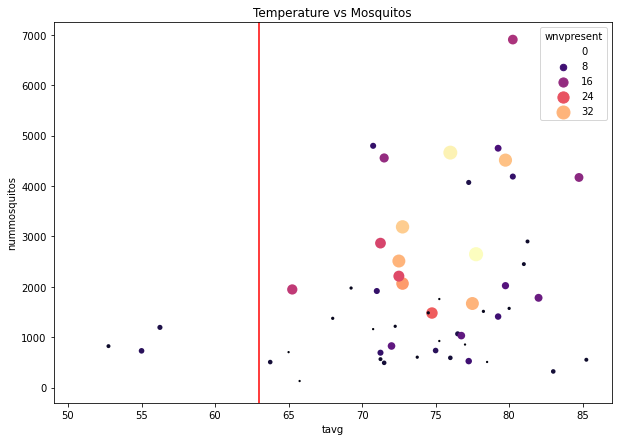

In [65]:
# plot mosquitos vs temperature
plt.figure(figsize=(10,7))
sns.scatterplot(data=mos_vs_weather, x='tavg', y='nummosquitos', size='wnvpresent', sizes=(0,200), hue='wnvpresent',
                palette='magma')
plt.axvline(x=63, c='red')
plt.title('Temperature vs Mosquitos');

For temperatures above 63&deg;F, we can see that number of mosquitos and west nile clusters are more prevalent.

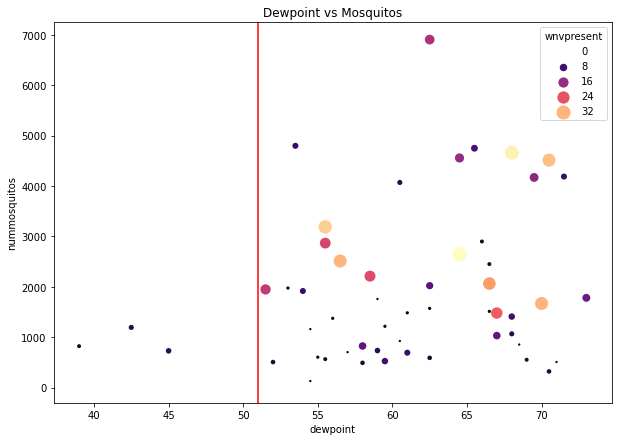

In [66]:
# plot mosquitos vs dewpoint
plt.figure(figsize=(10,7))
sns.scatterplot(data=mos_vs_weather, x='dewpoint', y='nummosquitos', size='wnvpresent', sizes=(0,200), hue='wnvpresent',
                palette='magma')
plt.axvline(x=51, c='red')
plt.title('Dewpoint vs Mosquitos');

For DewPoint above 51&deg;F, we can see that number of mosquitos and west nile clusters are more prevalent.

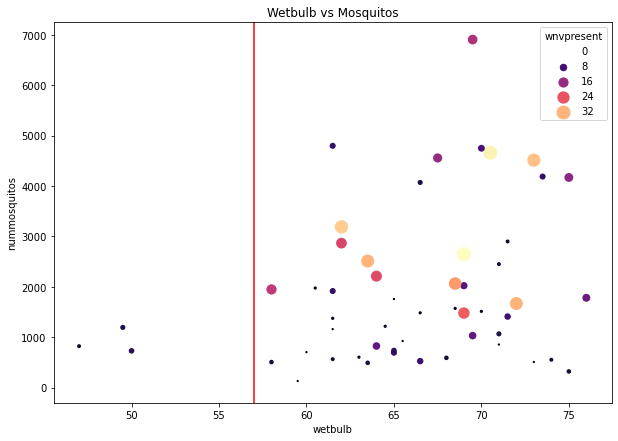

In [67]:
# plot mosquitos vs wetbulb
plt.figure(figsize=(10,7))
sns.scatterplot(data=mos_vs_weather, x='wetbulb', y='nummosquitos', size='wnvpresent', sizes=(0,200), hue='wnvpresent',
                palette='magma')
plt.axvline(x=57, c='red')
plt.title('Wetbulb vs Mosquitos');

For WetBulb above 57&deg;F, we can see that number of mosquitos and west nile clusters are more prevalent.

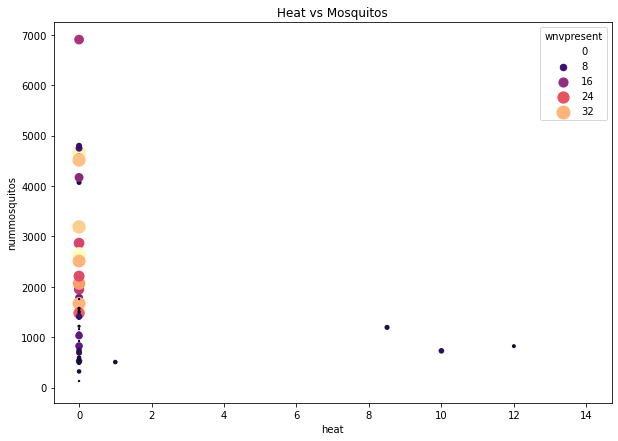

In [68]:
# plot mosquitos vs heat
plt.figure(figsize=(10,7))
sns.scatterplot(data=mos_vs_weather, x='heat', y='nummosquitos', size='wnvpresent', sizes=(0,200), hue='wnvpresent',
                palette='magma')
# plt.axvline(x=57, c='red')
plt.title('Heat vs Mosquitos');

Most of the `heat` values were 0. No clear relation can be inferred. Hence we can drop this feature.

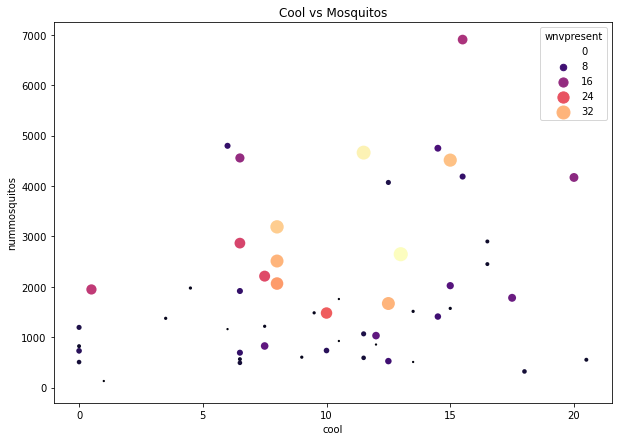

In [69]:
# plot mosquitos vs cool
plt.figure(figsize=(10,7))
sns.scatterplot(data=mos_vs_weather, x='cool', y='nummosquitos', size='wnvpresent', sizes=(0,200), hue='wnvpresent',
                palette='magma')
# plt.axvline(x=57, c='red')
plt.title('Cool vs Mosquitos');

As can be seen from the graph, we can see that for `cool`, the clusters are spread evenly across the graph. There is no clear boundary for which the number of mosquitos and wnv are present/absent. Hence, we can drop this feature. 

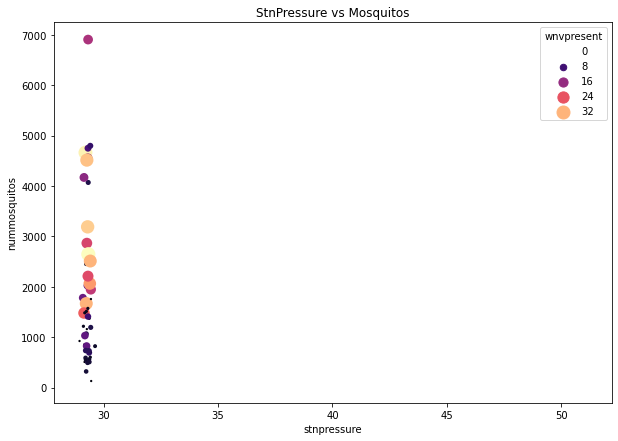

In [70]:
# plot mosquitos vs stnpressure
plt.figure(figsize=(10,7))
sns.scatterplot(data=mos_vs_weather, x='stnpressure', y='nummosquitos', size='wnvpresent', sizes=(0,200), hue='wnvpresent',
                palette='magma')
# plt.axvline(x=57, c='red')
plt.title('StnPressure vs Mosquitos');

Similar to `heat` above, no clear relation can be inferred from `stnpressure`. We may drop this feature as well.

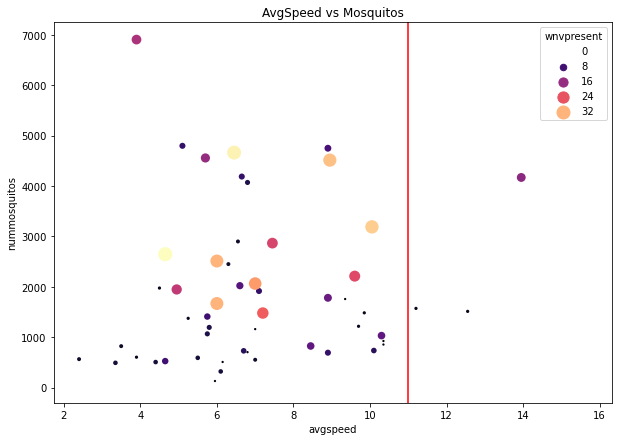

In [71]:
# plot mosquitos vs avgspeed
plt.figure(figsize=(10,7))
sns.scatterplot(data=mos_vs_weather, x='avgspeed', y='nummosquitos', size='wnvpresent', sizes=(0,200), hue='wnvpresent',
                palette='magma')
plt.axvline(x=11, c='red')
plt.title('AvgSpeed vs Mosquitos');

From the graph, we can see that number of mosquitos and wnv clusters are more prevalent at `avgspeed` below 11 miles/hour.

# 6. EDA on `spray`

In [72]:
print(spray.shape)
spray.head()

(14835, 4)


,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [73]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [74]:
# lowercase the column names
spray.columns= spray.columns.str.lower()
spray.columns

Index(['date', 'time', 'latitude', 'longitude'], dtype='object')

## 6.1 Missing Values & Duplicates

In [75]:
# check the missing values
print(spray.isnull().sum() / spray.shape[0] *100)
print()
print(spray.isnull().sum())

date         0.000000
time         3.936636
latitude     0.000000
longitude    0.000000
dtype: float64

date           0
time         584
latitude       0
longitude      0
dtype: int64


In [76]:
# Check duplicates
spray['time'].value_counts().loc[spray['time'].value_counts() > 1]

7:44:32 PM    541
8:57:46 PM      5
9:31:27 PM      5
9:35:47 PM      5
9:37:27 PM      5
             ... 
8:21:22 PM      2
8:22:32 PM      2
8:15:12 PM      2
8:22:22 PM      2
8:07:51 PM      2
Name: time, Length: 3651, dtype: int64

In [77]:
spray[spray['time'] == '7:44:32 PM']

,date,time,latitude,longitude
489,2011-09-07,7:44:32 PM,41.98646,-87.794225
490,2011-09-07,7:44:32 PM,41.98646,-87.794225
491,2011-09-07,7:44:32 PM,41.98646,-87.794225
492,2011-09-07,7:44:32 PM,41.98646,-87.794225
493,2011-09-07,7:44:32 PM,41.98646,-87.794225
...,...,...,...,...
1025,2011-09-07,7:44:32 PM,41.98646,-87.794225
1026,2011-09-07,7:44:32 PM,41.98646,-87.794225
1027,2011-09-07,7:44:32 PM,41.98646,-87.794225
1028,2011-09-07,7:44:32 PM,41.98646,-87.794225


In [78]:
spray.drop_duplicates(inplace=True) # drop duplicates rows
print(spray.shape)

(14294, 4)


In [79]:
spray['time'].value_counts().loc[spray['time'].value_counts() > 1]

8:57:56 PM    5
8:59:06 PM    5
9:31:27 PM    5
9:35:47 PM    5
9:37:27 PM    5
             ..
8:17:42 PM    2
8:19:32 PM    2
9:50:27 PM    2
8:19:42 PM    2
8:14:22 PM    2
Name: time, Length: 3649, dtype: int64

In [80]:
spray[spray['time'] == '8:57:56 PM']

,date,time,latitude,longitude
1982,2011-09-07,8:57:56 PM,41.975508,-87.815767
4440,2013-07-25,8:57:56 PM,41.949442,-87.736702
5678,2013-07-25,8:57:56 PM,41.961702,-87.729127
8349,2013-08-15,8:57:56 PM,41.905018,-87.767047
13759,2013-08-29,8:57:56 PM,41.986075,-87.681948


In [81]:
# drop `time` column
spray.drop('time', axis=1, inplace=True)
spray.head()

,date,latitude,longitude
0,2011-08-29,42.391623,-88.089163
1,2011-08-29,42.391348,-88.089163
2,2011-08-29,42.391022,-88.089157
3,2011-08-29,42.390637,-88.089158
4,2011-08-29,42.390410,-88.088858


In [82]:
spray.isnull().sum()

date         0
latitude     0
longitude    0
dtype: int64

In [83]:
print(f"Spray Periods From: {spray['date'].min()} to {spray['date'].max()}")
spray['date'].value_counts().sort_index()

Spray Periods From: 2011-08-29 to 2013-09-05


2011-08-29      95
2011-09-07    1573
2013-07-17    2202
2013-07-25    1607
2013-08-08    1195
2013-08-15    2668
2013-08-16     141
2013-08-22    1587
2013-08-29    2302
2013-09-05     924
Name: date, dtype: int64

- Although the spray periods is between 2011-08-29 to 2013-09-05, there was no spray in 2012.
- Only 2 days spray in 2011 and 8 days spray in 2013.
- Will explore further on the effect of the spray after the spray.

In [84]:
# convert the date to correct format
spray['date'] = pd.to_datetime(spray['date'])
spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14294 entries, 0 to 14834
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       14294 non-null  datetime64[ns]
 1   latitude   14294 non-null  float64       
 2   longitude  14294 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 446.7 KB


In [85]:
# get year, month, week and day of the rows in the spray dataset
spray['spray_year'] = spray['date'].dt.year
spray['spray_month'] = spray['date'].dt.month
spray['spray_week'] = spray['date'].dt.isocalendar().week.astype('int') 
spray['spray_day'] = spray['date'].dt.day

spray.head()

,date,latitude,longitude,spray_year,spray_month,spray_week,spray_day
0,2011-08-29,42.391623,-88.089163,2011,8,35,29
1,2011-08-29,42.391348,-88.089163,2011,8,35,29
2,2011-08-29,42.391022,-88.089157,2011,8,35,29
3,2011-08-29,42.390637,-88.089158,2011,8,35,29
4,2011-08-29,42.390410,-88.088858,2011,8,35,29


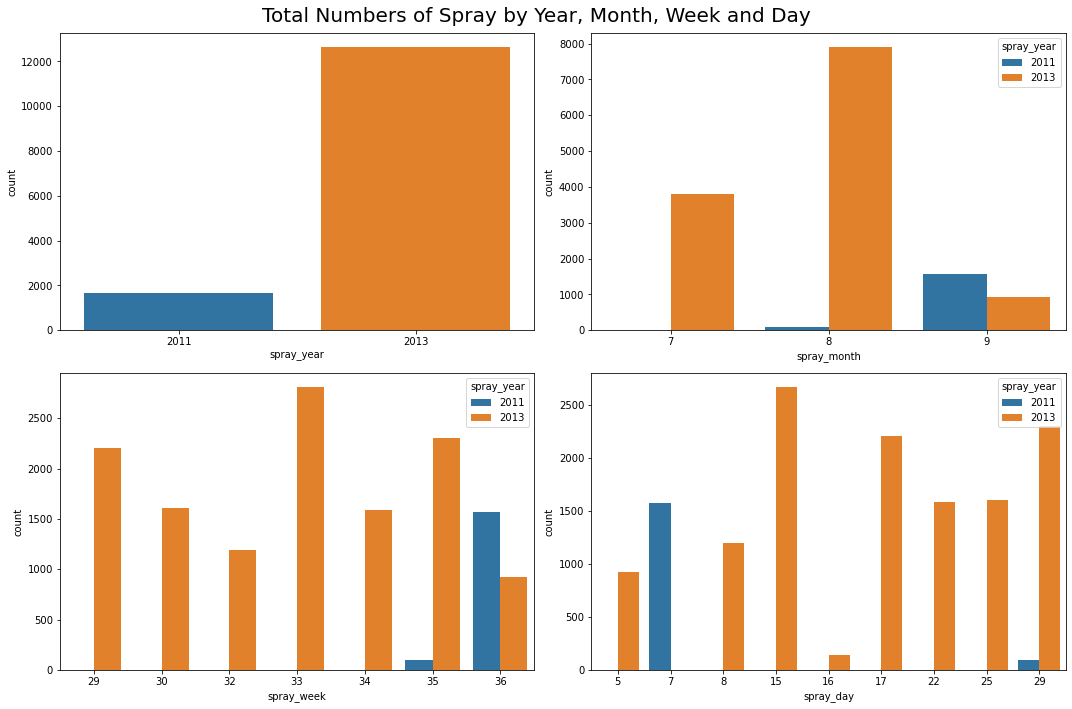

In [86]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
sns.countplot(data= spray, x='spray_year',ax=ax[0,0])
sns.countplot(data= spray, x='spray_month',ax=ax[0,1], hue='spray_year')
sns.countplot(data= spray, x='spray_week',ax=ax[1,0], hue='spray_year')
sns.countplot(data= spray, x='spray_day',ax=ax[1,1], hue='spray_year')
fig.suptitle('Total Numbers of Spray by Year, Month, Week and Day', fontsize=20)
fig.tight_layout();

- From bar chart, it shows that there was more spray in 2013 than 2011 and it was focusing on the month of July August and September
- There was no specific days of spray, but it was sprayed between week 29 to week 36 of the year

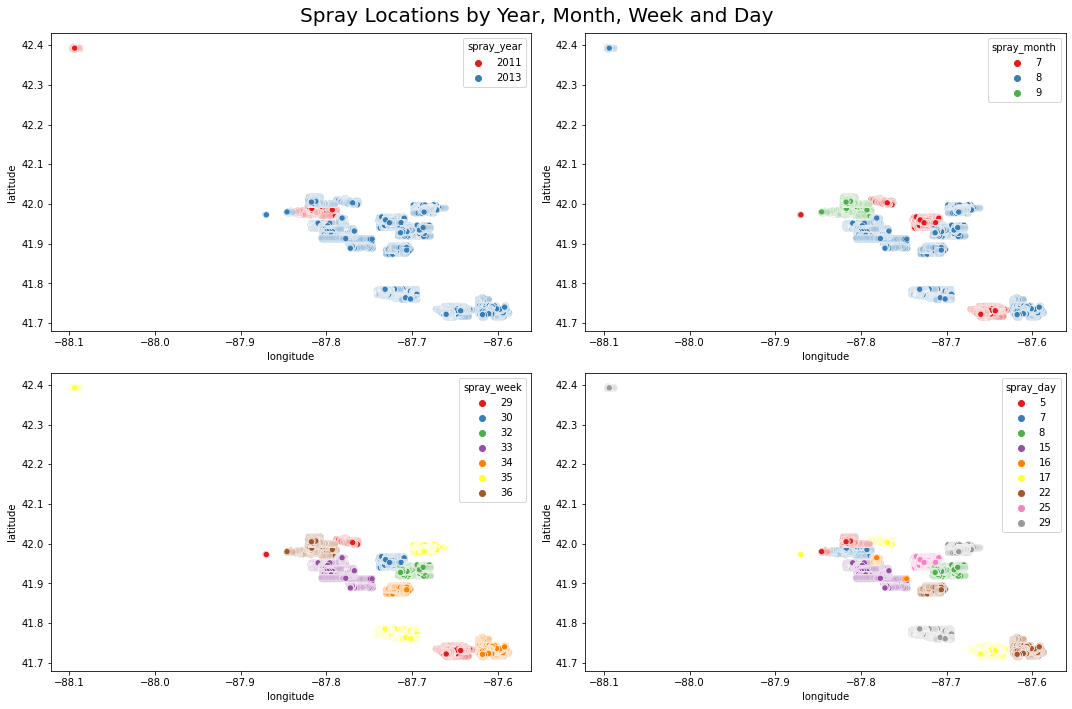

In [87]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
sns.scatterplot(data= spray, y='latitude',x='longitude',ax=ax[0,0], hue='spray_year', palette='Set1', ci=0)
sns.scatterplot(data= spray, y='latitude',x='longitude',ax=ax[0,1], hue='spray_month', palette='Set1')
sns.scatterplot(data= spray, y='latitude',x='longitude',ax=ax[1,0], hue='spray_week', palette='Set1')
sns.scatterplot(data= spray, y='latitude',x='longitude',ax=ax[1,1], hue='spray_day', palette='Set1')
fig.suptitle('Spray Locations by Year, Month, Week and Day', fontsize=20)
fig.tight_layout();

In [88]:
spray[spray['longitude'] < -88]

,date,latitude,longitude,spray_year,spray_month,spray_week,spray_day
0,2011-08-29,42.391623,-88.089163,2011,8,35,29
1,2011-08-29,42.391348,-88.089163,2011,8,35,29
2,2011-08-29,42.391022,-88.089157,2011,8,35,29
3,2011-08-29,42.390637,-88.089158,2011,8,35,29
4,2011-08-29,42.390410,-88.088858,2011,8,35,29
...,...,...,...,...,...,...,...
90,2011-08-29,42.392902,-88.093853,2011,8,35,29
91,2011-08-29,42.392587,-88.093867,2011,8,35,29
92,2011-08-29,42.392308,-88.093873,2011,8,35,29
93,2011-08-29,42.392183,-88.093767,2011,8,35,29


From the Scatterplot, it shows that the spray in 2011-08-29 was an outlier which had 95 sprays on the same day, and at the same area.

## 6.2 Map and Spray

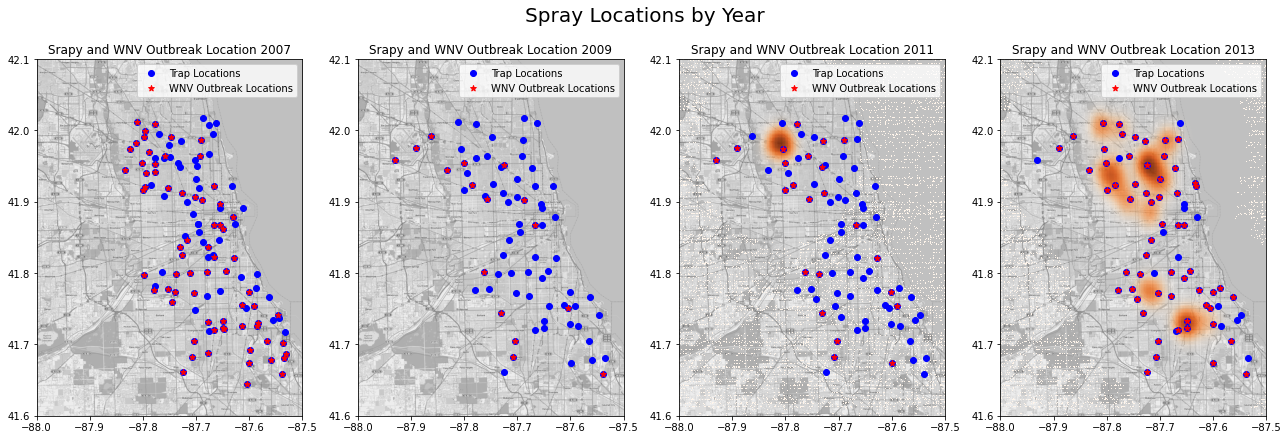

In [89]:
# load the map
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

alpha_cm = plt.cm.Oranges
alpha_cm._init()
alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

fig, ax = plt.subplots(ncols=4, figsize=(18,12))

for i, year in enumerate(train['date'].dt.year.unique()):
    
    train_map = train.set_index('date').loc[str(year)].copy()
    
    # Spray location
    if year in spray['spray_year'].values:
        X = spray[spray['spray_year'] == year][['longitude', 'latitude']].values
        kd = KernelDensity(bandwidth=0.015)
        kd.fit(X)
    
        xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
        gridpoints = np.array([xv.ravel(),yv.ravel()]).T
        zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))
        
        ax[i].imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
        ax[i].imshow(zv, origin='lower', cmap=alpha_cm, extent=lon_lat_box, aspect=aspect)

        # trap locations
        trap_locations = train_map[['longitude', 'latitude']].drop_duplicates().values
        ax[i].scatter(trap_locations[:,0], trap_locations[:,1], marker='o', c='b', label='Trap Locations')

        # wnn outbreak locations
        wnv_locations = train_map[(train_map['wnvpresent'] != 0)][['longitude', 'latitude']].drop_duplicates().values
        ax[i].scatter(wnv_locations[:,0], wnv_locations[:,1], marker='*', c='r', label='WNV Outbreak Locations')

        ax[i].legend(fontsize=8)
        ax[i].set_title('Srapy and WNV Outbreak Location 2011')
        
        plt.tight_layout()

        ax[i].legend(fontsize=10)
        ax[i].set_title(f'Srapy and WNV Outbreak Location {year}')
        
    else:
        
        ax[i].imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
        
        # trap locations
        trap_locations = train_map[['longitude', 'latitude']].drop_duplicates().values
        ax[i].scatter(trap_locations[:,0], trap_locations[:,1], marker='o', c='b', label='Trap Locations')
        
        # wnn outbreak locations
        wnv_locations = train_map[(train_map['wnvpresent'] != 0)][['longitude', 'latitude']].drop_duplicates().values
        ax[i].scatter(wnv_locations[:,0], wnv_locations[:,1], marker='*', c='r', label='WNV Outbreak Locations')
        plt.tight_layout()

        ax[i].legend(fontsize=10)
        ax[i].set_title(f'Srapy and WNV Outbreak Location {year}')
        

fig.suptitle('Spray Locations by Year', fontsize=20, y=0.75)
fig.tight_layout();

- In 2007 and 2009, there were no spray efforts in City of Chicago. Spraying started in 2011, and in 2013, the spraying areas were expanded.

In [90]:
# Spray location
X = spray[['longitude', 'latitude']].values

kd = KernelDensity(bandwidth=0.015)
kd.fit(X)

xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
gridpoints = np.array([xv.ravel(),yv.ravel()]).T
zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))

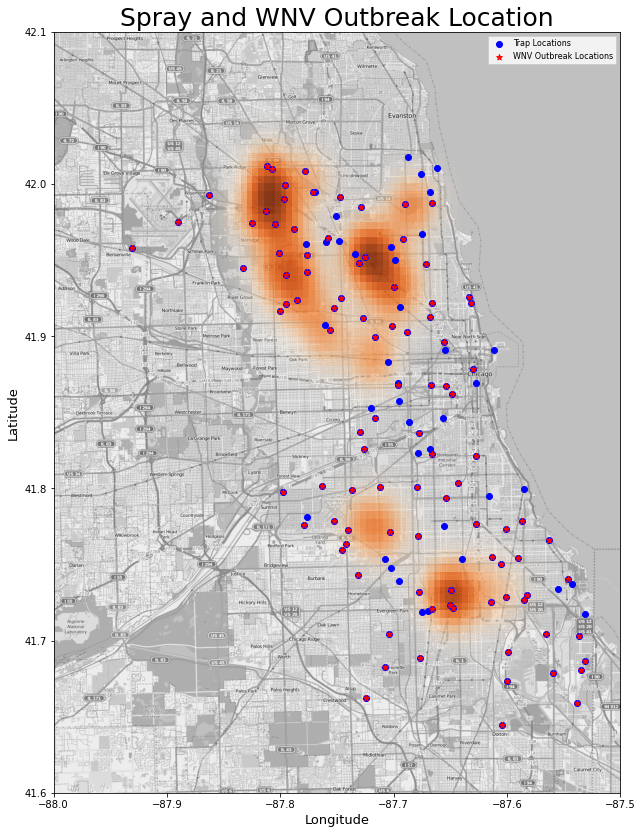

In [91]:
fig, ax = plt.subplots(figsize=(15,14))

plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
plt.imshow(zv, origin='lower', cmap=alpha_cm, extent=lon_lat_box, aspect=aspect)


# trap locations
trap_locations = train[['longitude', 'latitude']].drop_duplicates().values
plt.scatter(trap_locations[:,0], trap_locations[:,1], marker='o', c='b', label='Trap Locations')


# wnn outbreak locations
wnv_locations = train[(train['wnvpresent'] != 0)][['longitude', 'latitude']].drop_duplicates().values
plt.scatter(wnv_locations[:,0], wnv_locations[:,1], marker='*', c='r', label='WNV Outbreak Locations')


plt.legend(fontsize=8)
plt.title('Spray and WNV Outbreak Location', fontsize=25)

plt.xlabel('Longitude', fontsize=13)
plt.ylabel('Latitude', fontsize=13);

From the map above, although the spray cover numbers of WNV outbreak locations, it was not cover full of the City. It may be due to the cost concern to spray for large area.

## 6.3 Spray Effect

In [92]:
# create a function to check the effect of spray
def spray_effect(target, year):
    fig, ax = plt.subplots(figsize=(10,5))
    temp = train[train['year']==year].groupby('week')[target].sum().to_frame()
    
    sns.lineplot(x=temp.index, y=temp[target], ci=None, label=f"{target}")
    
    if year in spray['spray_year'].unique():
        for week in spray[spray['spray_year']==year].groupby('spray_week').mean().index:
            plt.axvline(week, linestyle='--', color='red', alpha=0.5, label='Spray')
    
    plt.legend([f"{target}",'Spray'])
    plt.title(f"Spray Effect on {target} of Year {year}", fontsize=20)                     

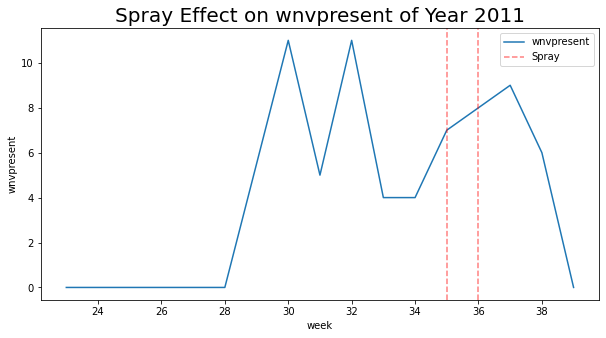

In [93]:
# spray effect in 2011 showing wnvpresent
spray_effect('wnvpresent', 2011)

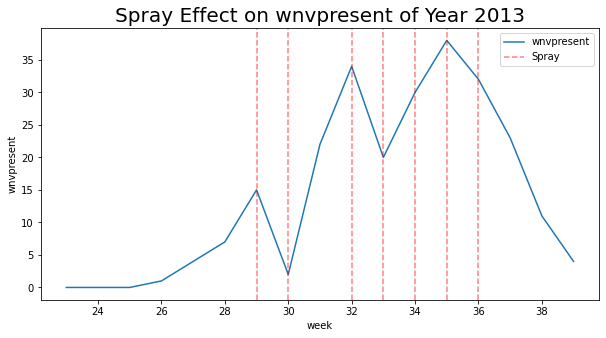

In [94]:
# spray effect in 2013 showing wnvpresent
spray_effect('wnvpresent', 2013)

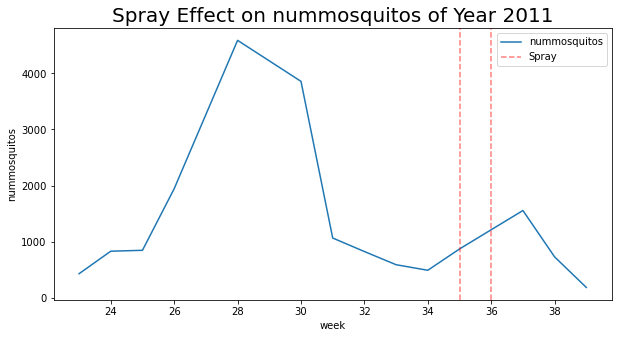

In [95]:
# spray effect in 2011 showing number of mosquitos
spray_effect('nummosquitos', 2011)

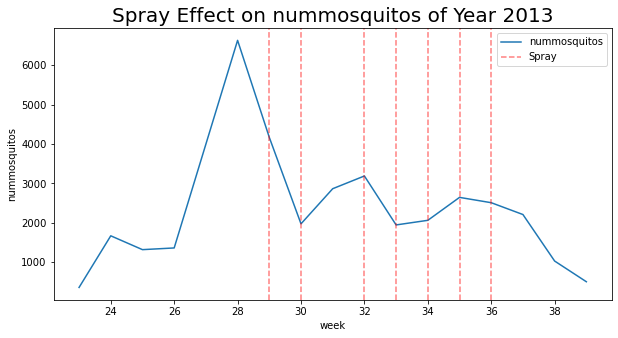

In [96]:
# spray effect in 20113 showing number of mosquitos
spray_effect('nummosquitos', 2013)

- Our Spray Dataset was limited as we only have 2 years of spray data. In year 2011, only 2 sprays were carried out, while there were much more sprays carried out in year 2013.
- From the lineplot above, we cannot conclude that the sprays have strong effect on reducing the WNV present cases. It does, however have effect on reducing the number of mosquitos in both year 2011 and 2013.

# Export the cleaned datasets

In [97]:
# export train
train.to_csv('../assets/train_clean.csv', index=False)

# export test
test.to_csv('../assets/test_clean.csv', index=False)

# export weather
weather.to_csv('../assets/weather_clean.csv', index=False)

# export spray
spray.to_csv('../assets/spray_clean.csv', index=False)

# References
1. https://dph.illinois.gov/topics-services/diseases-and-conditions/west-nile-virus.html